<a href="https://www.kaggle.com/code/maximlaletin/naive-bayes-for-disaster-tweets?scriptVersionId=217473719" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Import functions from scikit-learning package
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import time

# Data

In [3]:
data_pack = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
inference_pack = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
data_size = data_pack.shape[0] # number of rows 
print('Number of rows = ',data_size)
data_pack.head(5) # display the first five rows

Number of rows =  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Check if the training dataframe has any duplicates and remove them

In [5]:
#row_counts = data_pack.drop(columns=["id"]).value_counts(dropna=False)

#row_counts_df = row_counts.reset_index(name='Count')
#print(row_counts_df)

data_pack_unique = data_pack.drop(columns=["id"]).drop_duplicates()
data_size_unique = data_pack_unique.shape[0]
print('Number of rows after removing duplicates = ',data_size_unique)

Number of rows after removing duplicates =  7561


Split the dataframe into a training and test data sets (to measure the performance of the method)

In [6]:
train_data, test_data, train_target, test_target = train_test_split(data_pack_unique.drop(columns=["target"]), data_pack_unique["target"], test_size=0.1, random_state=56)

In [7]:
# Save al the tweets into a textfile for a convenient examination

#with open('/kaggle/working/texts.txt', 'w') as file:
#    file.write('\n'.join(train_data[' Merge the text from all columns into a single column, ignoring NaN valuestext']))

 Merge the text from all columns into a single column, ignoring NaN values

In [8]:
train_data['merged'] = train_data.fillna('').agg(' '.join, axis=1).str.strip()
test_data['merged'] = test_data.fillna('').agg(' '.join, axis=1).str.strip()

# Naive Bayes method

In [9]:
from collections import defaultdict # default dictionary - provides a default value for the key that doesn't exist
import re # regular expression operations

class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {} # priors
        self.word_counts = defaultdict(lambda: defaultdict(int)) # dictionary of words contained in each label class after training
        self.vocab = set() # vocabulary of the classifier
        self.total_words_per_class = defaultdict(int) # total number of the words used for the training of a given label
        self.maxlen = 30 # maximal length of the word that is processed by the classifier
        self.minlen = 1 # minimal length of the word that is processes by the classifier

    def preprocess(self, text):
        """Preprocesses the text"""
        text = text.lower() # lowercasing the text
        #text = re.sub(r'[^a-z0-9\s]', '', text) 
        text = re.sub(r"https?://t\.co/",'', text) # leaving only the Twitter identifier from the address
        text = re.sub(r'[\/\;\.\&\@\!\~]',' ',text) # splitting the words that contain these symbols (or simply removing these symbols)
        text = re.sub(r'[^a-z0-9\s\-\:]', '', text) # removing non-numerical and non-alphabetical elements (except for "-" and ":")
        return text.split() # splits the string into a list of words as items

    def fit(self, texts, labels):
        """Trains the classifier on the training data."""
        n_samples = len(labels)

        # Calculate class priors
        for label in labels:
            self.class_priors[label] = self.class_priors.get(label, 0) + 1

        for text, label in zip(texts, labels):
            words = self.preprocess(text)
            for word in words:
                # ignore the words that are shorter than minlen or longer than maxlen
                if len(word) > self.minlen and len(word) < self.maxlen:
                    self.word_counts[label][word] += 1
                    self.total_words_per_class[label] += 1
                    self.vocab.add(word)

        # Normalize class priors
        for label in self.class_priors:
            self.class_priors[label] /= n_samples

    def clean(self, min_freq):
        """Remove all the words that occur in the word counts less than min_freq times"""

        for label in range(len(self.word_counts)):

            for word in list(self.word_counts[label].keys()):
                if self.word_counts[label][word] < min_freq:
                    self.total_words_per_class[label] -= self.word_counts[label][word]
                    del self.word_counts[label][word]
                    self.vocab.discard(word) # remove from the vocabulary

        # Add words to the vocabulary if they were deleted from one label word list, but still present in the second
        for label in range(len(self.word_counts)):

            for word in list(self.word_counts[label].keys()):
                self.vocab.add(word)
            
        
    def predict(self, texts):
        """Predicts class labels for a list of texts."""
        predictions = []

        for text in texts:
            words = self.preprocess(text)
            class_scores = {}

            for label in self.class_priors:
                # Start with the log of the prior probability
                class_scores[label] = np.log(self.class_priors[label])

                for word in words:
                    if len(word) > self.minlen and len(word) < self.maxlen and word in self.vocab:
                        # Apply Laplace smoothing
                        word_likelihood = (
                            self.word_counts[label].get(word, 0) + 1
                        ) / (self.total_words_per_class[label] + len(self.vocab))
                        class_scores[label] += np.log(word_likelihood)

            # Choose the class with the highest score
            predictions.append(max(class_scores, key=class_scores.get))

        return predictions

## Initialize and train the classifier

In [10]:
classifier = NaiveBayesClassifier()

start_time = time.time()
classifier.fit(train_data['merged'], train_target)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

Elapsed time: 0.15373992919921875 s


Remove all the words and signs that occur in the counts less than 2 times (not really necessary, but make the word pool of the classifier a bit cleaner)

In [11]:
classifier.clean(2)

Display how many words were encountered during the training for each label class and the total size of the classifier's vocabulary

In [12]:
disaster_words = classifier.total_words_per_class[1]
non_disaster_words = classifier.total_words_per_class[0]
vocabulary_size = len(classifier.vocab)

In [13]:
print('disaster_words = ',disaster_words)
print('non disaster_words = ',non_disaster_words)
print('total vocabulary = ',vocabulary_size)

disaster_words =  40934
non disaster_words =  52034
total vocabulary =  6211


In [14]:
# Show the dictionary of words encountered during the training for non-disaster tweets and their frequency
#dict(sorted(classifier.word_counts[0].items(),key=lambda item: item[1],reverse=True))

Count the frequency of different words in a class and display the distribution of frequencies

In [15]:
from collections import Counter

# Step 1: Extract the frequencies of words in disaster tweets
frequencies = list(classifier.word_counts[1].values())

# Step 2: Count the number of words with each frequency
freq_of_freq = Counter(frequencies)

# Step 3: Prepare data for plotting
x = list(freq_of_freq.keys())   # Unique frequencies
y = list(freq_of_freq.values()) # Number of words with each frequency

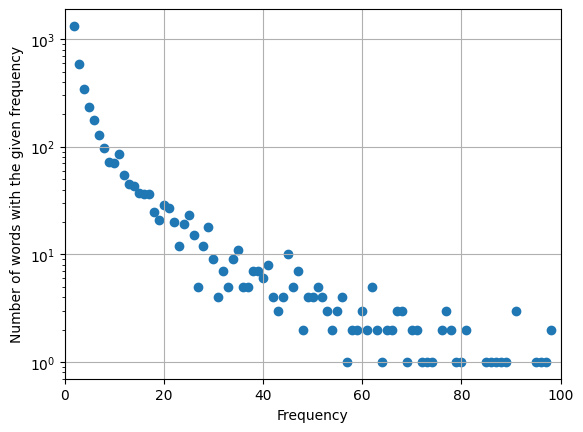

In [16]:
import matplotlib.pyplot as plt

plt.figure()
#plt.hist(frequencies,bins=2000)
#plt.xlim([0,25])
plt.scatter(x,y)
plt.xlim([0,100])
plt.yscale('log')
plt.grid()
plt.xlabel('Frequency')
plt.ylabel('Number of words with the given frequency')
plt.show()

Show how many tweets correspond to each label class (disaster or non-disaster)

In [17]:
n_disaster = train_target[train_target == 1].shape[0]
n_non_disaster = train_target[train_target == 0].shape[0]

In [18]:
print('Number of disaster tweets = ',n_disaster)
print('Number of other tweets = ',n_non_disaster)

Number of disaster tweets =  2937
Number of other tweets =  3867


## Predictions for the test data set

In [19]:
start_time = time.time()
predictions = classifier.predict(test_data['merged'])
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

Elapsed time: 0.05300116539001465 s


Measure the performance of the method on the test dataset

In [20]:
f1 = f1_score(test_target, predictions)
print('F1-score = ',f1)

F1-score =  0.7379310344827585


## Training and prediction for the inference data set

Now we use the full training data set to train the classifier and use it to classify the inference data

In [21]:
full_train_data = data_pack_unique.drop(columns=['target']).fillna('').agg(' '.join, axis=1).str.strip() # apply all the filters as previously done
full_train_target = data_pack_unique['target']

In [22]:
classifier_full = NaiveBayesClassifier()
classifier_full.fit(full_train_data, full_train_target)
classifier_full.clean(2)

In [23]:
inference_data = inference_pack.drop(columns=['id']).fillna('').agg(' '.join, axis=1).str.strip()

In [24]:
start_time = time.time()
main_prediction = classifier_full.predict(inference_data)
end_time = time.time()

print(f'Elapsed time: {end_time - start_time} s')

Elapsed time: 0.21660161018371582 s


Create the dataframe for predictions in accordance with the requirements and export it to a csv file

In [25]:
prediction_df = pd.DataFrame(inference_pack['id'].copy())
prediction_df['target'] = main_prediction

prediction_df.to_csv('submission.csv', index=False)

Take a peak at the resulting dataframe

In [26]:
prediction_df.head(5)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
